<a href="https://colab.research.google.com/github/hm575/PBTNB.score/blob/main/PHS597_HW3v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [86]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [ ]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.8.0


Get dataset from UCI machine learning repository. 

In [ ]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [ ]:
# make a copy of the raw data
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


Check for missing data and remove those entries or rows

In [ ]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [ ]:
dataset = dataset.dropna()
dataset.shape

(392, 8)

In [ ]:
dataset['Origin'].value_counts()

1    245
3     79
2     68
Name: Origin, dtype: int64

The `Origin` column is categorical for countries. Create dummy variables for them.

In [ ]:
dataset['Origin'] = dataset['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})
dataset = pd.get_dummies(dataset, columns=['Origin'], prefix='', prefix_sep='')
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0,0,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,1,0,0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0,0,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,0,0,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,0,0,1


Split data into training and test sets

In [ ]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

Joint distribution of some of the variables in the data

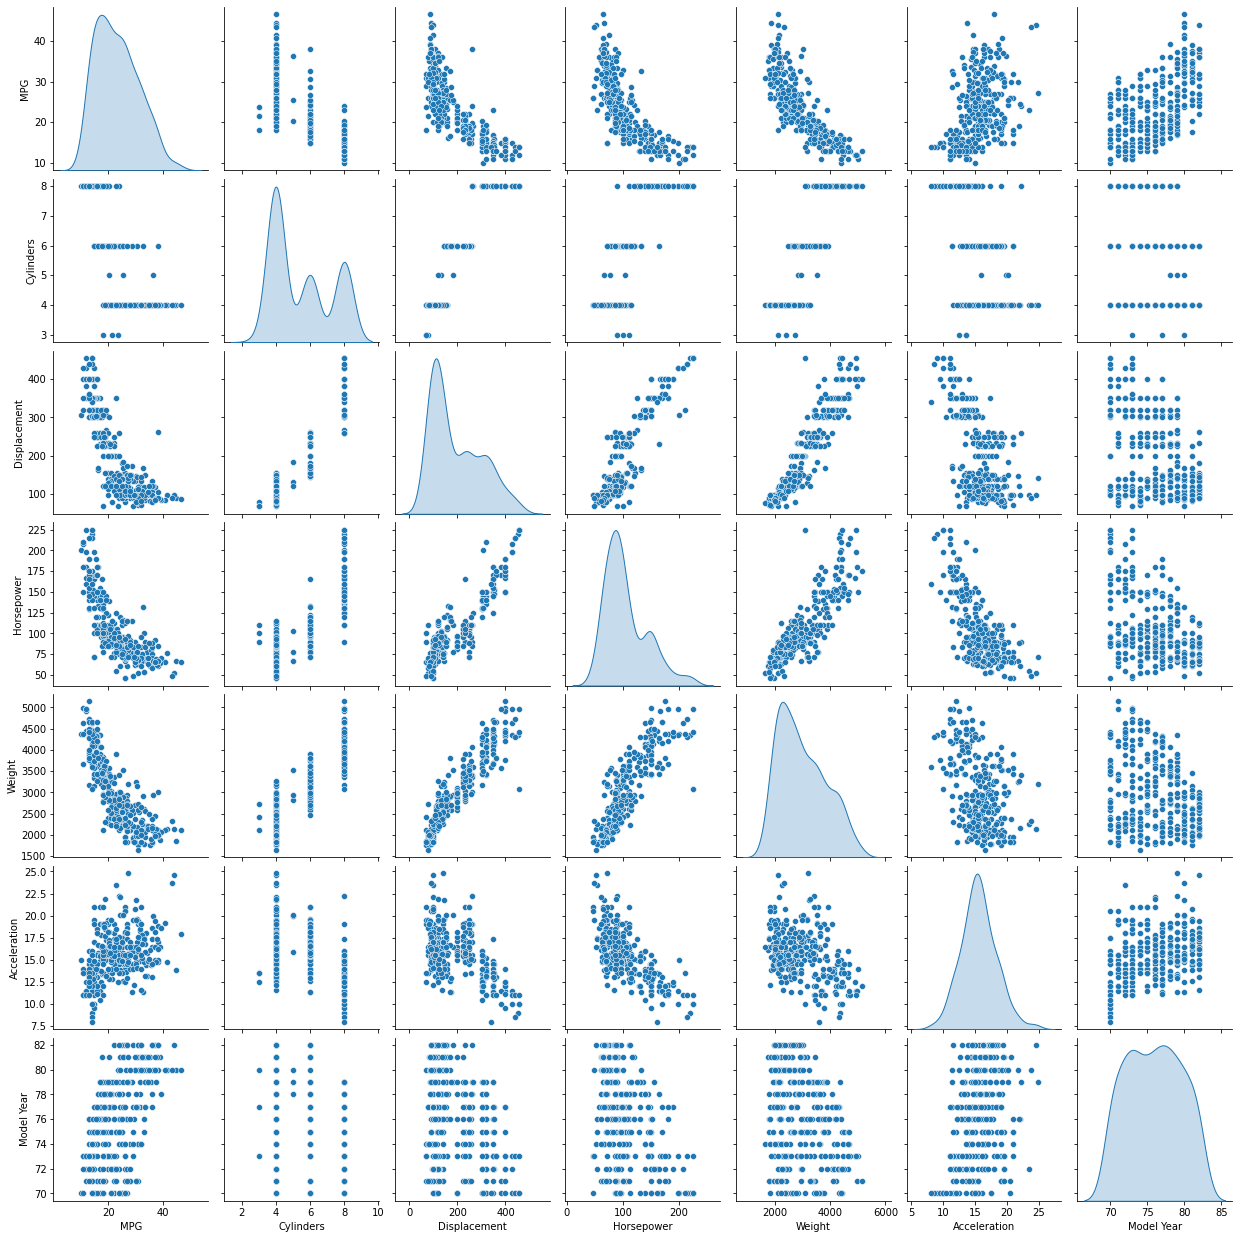

In [ ]:
sns.pairplot(train_dataset.drop(['Europe', 'Japan', 'USA'], axis=1), diag_kind='kde')

Get training and testing labels

In [ ]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

Normalizing data

In [ ]:
# Create a Normalization layer and set its internal state using the training data
normalizer = layers.Normalization()
normalizer.adapt(train_dataset)

In [ ]:
# mean of each predictor
normalizer.mean.numpy()

array([[   5.478,  195.318,  104.869, 2990.252,   15.559,   75.898,
           0.178,    0.197,    0.624]], dtype=float32)

In [ ]:
# the first entry
np.array(train_dataset.iloc[0,:])

array([   4. ,   90. ,   75. , 2125. ,   14.5,   74. ,    0. ,    0. ,
          1. ])

In [ ]:
# applying normalization to the first entry
normalizer(train_dataset.iloc[0,:])

<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
array([[-0.871, -1.011, -0.785, -1.027, -0.38 , -0.517, -0.466, -0.496,
         0.776]], dtype=float32)>

In [ ]:
normalizer(train_dataset)

<tf.Tensor: shape=(314, 9), dtype=float32, numpy=
array([[-0.871, -1.011, -0.785, ..., -0.466, -0.496,  0.776],
       [-0.871, -0.531, -0.444, ..., -0.466, -0.496,  0.776],
       [ 1.486,  1.485,  1.449, ..., -0.466, -0.496,  0.776],
       ...,
       [-0.871, -0.838, -0.312, ..., -0.466,  2.016, -1.289],
       [-0.871, -1.078, -1.153, ..., -0.466,  2.016, -1.289],
       [-0.871, -0.848, -0.496, ...,  2.146, -0.496, -1.289]],
      dtype=float32)>

## Simple linear regression model

* Simple linear regression mode with one predictor and one continious outcome
* Predict `MPG` from `Weight`

In [ ]:
# normalization layer
weight = np.array(train_dataset['Weight'])
weight_normalizer = layers.Normalization(input_shape=[1,], axis=None)
weight_normalizer.adapt(weight)

In [ ]:
# Keras sequential model
slr = keras.models.Sequential()
slr.add(weight_normalizer)
slr.add(layers.Dense(units=1, activation="linear", use_bias = True))
slr.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_7 (Dense)             (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


Configure the training procedure with `loss` and `optimizer`

In [ ]:
slr.compile(optimizer=tf.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

Fit the model

In [ ]:
history = slr.fit(train_dataset['Weight'], train_labels, epochs=100, verbose=0, validation_split = 0.1)

In [ ]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([-1, max(history.history['loss'])])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)

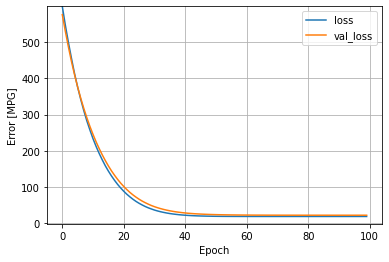

In [ ]:
plot_loss(history)

In [ ]:
x = tf.linspace(min(train_dataset['Weight']), max(train_dataset['Weight']), train_dataset.shape[0]+1)
y = slr.predict(x)

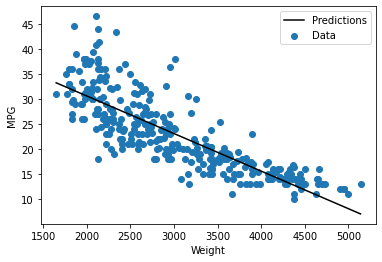

In [ ]:
plt.scatter(train_dataset['Weight'], train_labels, label='Data')
plt.plot(x, y, color='k', label='Predictions')
plt.xlabel('Weight')
plt.ylabel('MPG')
plt.legend()

In [ ]:
[np.array(slr.layers[1].kernel),np.array(slr.layers[1].bias)]

[array([[-6.327]], dtype=float32), array([23.222], dtype=float32)]

In [ ]:
from sklearn.linear_model import LinearRegression

x = np.array(train_dataset['Weight']).reshape(-1,1)
y = np.array(train_labels).reshape(-1,1)

x = (x-x.mean())/x.std()

reg = LinearRegression().fit(x, y)
[reg.intercept_, reg.coef_[0]]

[array([23.311]), array([-6.326])]

Text(0, 0.5, 'Keras Linear regression')

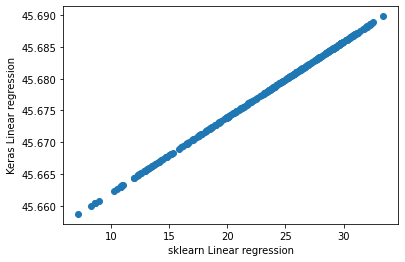

In [ ]:
plt.scatter(reg.coef_[0]*x + reg.intercept_, slr.predict(x))
plt.xlabel('sklearn Linear regression')
plt.ylabel('Keras Linear regression')

## Logistic regression

* Construct a binary outcome

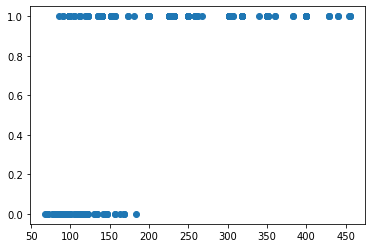

In [ ]:
plt.scatter(train_dataset['Displacement'], train_dataset['USA'], label='Data')

Going to try to predict whether the car is made in `USA` or `not`

```
# This is formatted as code
```

 using `Displacement`

In [ ]:
lr_train_feature = train_dataset['Displacement']
lr_train_labels = train_dataset['USA']

In [ ]:
#lr_train_labels = pd.concat([train_dataset['USA'], 
#           pd.DataFrame({'NotUSA' : train_dataset[['Japan','Europe']].sum(axis = 1)})], axis=1, ignore_index=True)


In [ ]:
# normalization layer
weight = np.array(lr_train_feature)
weight_normalizer = layers.Normalization(input_shape=[1,], axis=None)
weight_normalizer.adapt(weight)

* To implement Logistic regression, I will just apply the `sigmoid` activation to the first hidden layer.

In [ ]:
# Keras sequential model
lr = keras.models.Sequential()
lr.add(weight_normalizer)
lr.add(layers.Dense(units=1, activation="sigmoid", use_bias = True))
lr.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_6 (Normalizat  (None, 1)                3         
 ion)                                                            
                                                                 
 dense_14 (Dense)            (None, 1)                 2         
                                                                 
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


In [ ]:
lr.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
history = lr.fit(lr_train_feature, lr_train_labels, epochs=100, verbose=0, validation_split = 0.1)

In [ ]:
[np.array(lr.layers[1].kernel),np.array(lr.layers[1].bias)]

[array([[1.192]], dtype=float32), array([0.554], dtype=float32)]

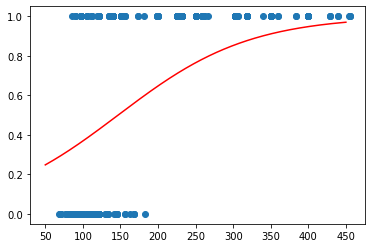

In [ ]:
plt.scatter(lr_train_feature, lr_train_labels, label='Data')
plt.plot(np.array(tf.linspace(50, 450, 500)).reshape(-1,1), 
            lr.predict(np.array(tf.linspace(50, 450, 500)).reshape(-1,1)), color='red')

In [ ]:
from sklearn.linear_model import LogisticRegression

x = np.array(lr_train_feature).reshape(-1,1)
y = np.array(lr_train_labels).reshape(-1,1)

x = (x-x.mean())/x.std()

lr_model = LogisticRegression(solver='liblinear', random_state=0)
lr_model = lr_model.fit(x, y)

[lr_model.intercept_, lr_model.coef_]

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[array([1.831]), array([[3.311]])]

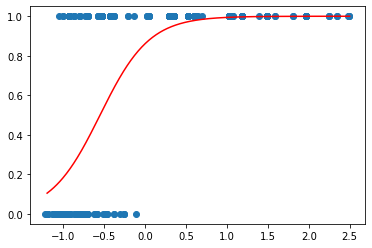

In [ ]:
plt.scatter(x, y, label='Data')
plt.plot(np.array(tf.linspace(-1.2, 2.5, 500)).reshape(-1,1),
         lr_model.predict_proba(np.array(tf.linspace(-1.2, 2.5, 500)).reshape(-1,1))[:,1], color='red', label='Predictions')

## SVM with hinge loss

Going to try to predict whether the car is made in `USA` or `not`*italicized text*

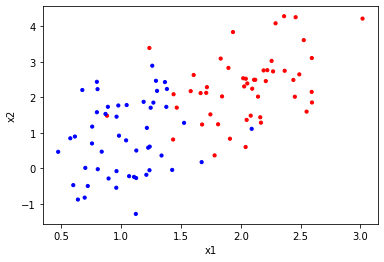

In [ ]:
np.random.seed(2021)
a1 = np.random.normal(loc=2, scale=0.4, size=50)
a2 = np.random.normal(loc=1, scale=0.3, size=50)
x1 = np.concatenate((a1, a2))
x2 = x1 + np.random.normal(size=100)

plt.scatter(x1, x2, c= ["red"]*50 + ["blue"]*50, s=10)
plt.ylabel('x2')
plt.xlabel('x1');

In [ ]:
train_df = pd.DataFrame({'x1':x1, 'x2':x2, 'y':[-1]*50 + [1]*50})
train_df.head()

,x1,x2,y
0,2.595444,1.854869,-1
1,2.270404,2.728638,-1
2,1.832619,3.089866,-1
3,1.677392,1.235688,-1
4,2.222350,2.763685,-1


In [ ]:
train_label = train_df.pop('y')

In [ ]:
# Keras sequential model
from keras.regularizers import l2
np.random.seed(221)

svm_hinge = keras.models.Sequential()
svm_hinge.add(keras.Input(shape=(2,)))
svm_hinge.add(layers.Dense(units=1,kernel_regularizer=l2(0.01)))

svm_hinge.summary()

svm_hinge.compile(loss='hinge',
              optimizer='adam',
              metrics=['accuracy'])

Model: "sequential_66"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_74 (Dense)            (None, 1)                 3         
                                                                 
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = svm_hinge.fit(train_df, train_label, epochs=100, verbose=0, validation_split = 0.1)

In [ ]:
svm_hinge.evaluate(train_df, train_label)

4/4 [==============================] - 0s 3ms/step - loss: 0.7516 - accuracy: 0.0000e+00


[0.7515565752983093, 0.0]

In [ ]:
beta_0 = np.array(svm_hinge.layers[0].bias)[0]
beta_1 = np.array(svm_hinge.layers[0].kernel)[0][0]
beta_2 = np.array(svm_hinge.layers[0].kernel)[1][0]
b = (-0.65-beta_0)/beta_2
m = -beta_1/beta_2

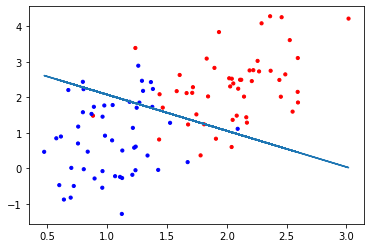

In [ ]:
plt.scatter(x1, x2, c= ["red"]*50 + ["blue"]*50, s=10)
plt.plot(x1, m*x1 + b)

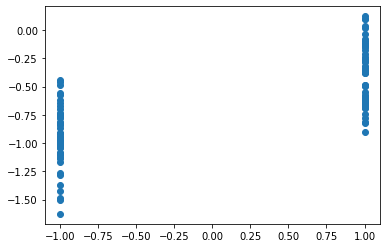

In [ ]:
plt.scatter(train_label, svm_hinge.predict(train_df))

## Support vector regression

* Predict `x2` from `x1`

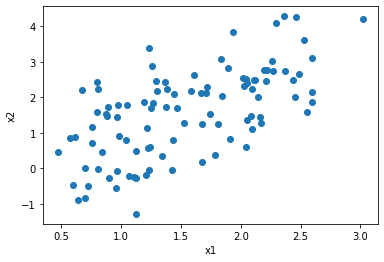

In [ ]:
plt.scatter(x1, x2)
plt.ylabel('x2')
plt.xlabel('x1');

In [ ]:
train_label2 = train_df.pop('x2')

In [ ]:
# Keras sequential model
from keras.regularizers import l2
np.random.seed(221)

svm_hinge = keras.models.Sequential()
svm_hinge.add(keras.Input(shape=(1,)))
svm_hinge.add(layers.Dense(units=1, activation="linear",
                           kernel_regularizer=l2(0.1)))

svm_hinge.summary()

svm_hinge.compile(loss='squared_hinge',
              optimizer='adam',
              metrics=['mean_squared_error'])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 2
Trainable params: 2
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = svm_hinge.fit(train_df, train_label2, epochs=100, verbose=0)

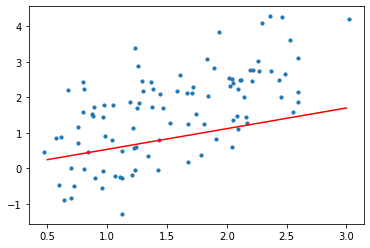

In [ ]:
plt.scatter(x1, x2, s=10)
plt.plot(np.array(tf.linspace(0.5, 3, 100)).reshape(-1,1), 
            svm_hinge.predict(np.array(tf.linspace(0.5, 3, 100)).reshape(-1,1)), color='red')

## Neural network for XOR function

In [87]:
np.random.chisquare(10, size=10)

array([13.245, 13.466, 11.401, 10.001, 20.603,  6.03 , 11.915,  6.381,
       11.328,  6.507])

In [88]:
np.random.seed(2021)
train_df = np.random.normal(loc=0, scale=1, size=(200, 10))
train_df = pd.DataFrame(train_df)

In [89]:
import scipy.stats
c = scipy.stats.chi2.ppf(0.5, df=10)

In [ ]:
#train_labels = 1*(np.power(train_df,2).sum(axis = 1) > c)

In [90]:
train_labels = (np.power(train_df,2).sum(axis = 1) > c)
yy = []
for i in range(train_labels.shape[0]):
  if train_labels[i]:
    yy.append(1)
  else:
    yy.append(0) 
train_labels = pd.DataFrame({'y':yy})

In [91]:
train_labels.value_counts()

y
0    105
1     95
dtype: int64

In [104]:
# Keras sequential model
xor_model = keras.models.Sequential()
xor_model.add(keras.Input(shape=(10,)))
xor_model.add(layers.Dense(units=32, activation="relu"))
xor_model.add(layers.Dense(units=1, activation="sigmoid"))

xor_model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 32)                352       
                                                                 
 dense_15 (Dense)            (None, 1)                 33        
                                                                 
Total params: 385
Trainable params: 385
Non-trainable params: 0
_________________________________________________________________


In [105]:
xor_model.compile(optimizer='adam',
                  loss='mean_squared_error',
                  metrics=['binary_accuracy'])

In [111]:
history = xor_model.fit(train_df, train_labels, epochs=200, verbose = 0)

In [112]:
xor_model.evaluate(train_df, train_labels)

7/7 [==============================] - 0s 4ms/step - loss: 0.0256 - binary_accuracy: 0.9950


[0.025634903460741043, 0.9950000047683716]

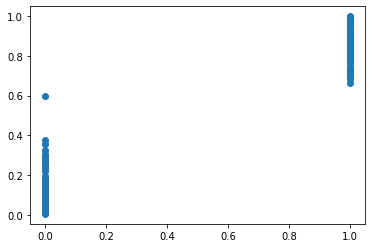

In [113]:
plt.scatter(train_labels, xor_model.predict(train_df), label='Data')